In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import savgol_filter
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [141]:
df = pd.read_excel("train.xlsx")
df["dt"] = pd.to_datetime(df["dt"])
df.set_index("dt", inplace=True)

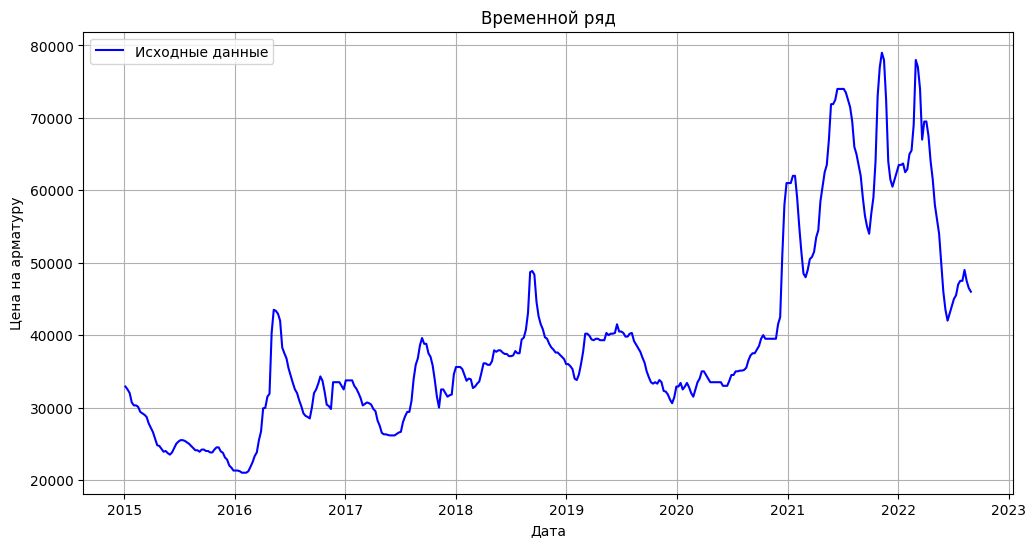

In [142]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Цена на арматуру"], label="Исходные данные", color="blue")
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Временной ряд")
plt.legend()
plt.grid()
plt.show()

<Figure size 1200x600 with 0 Axes>

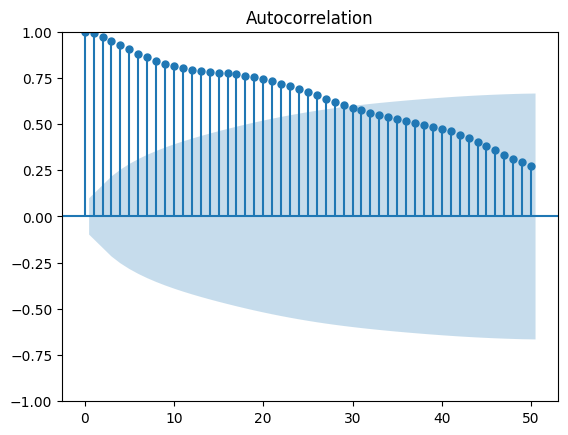

<Figure size 1200x600 with 0 Axes>

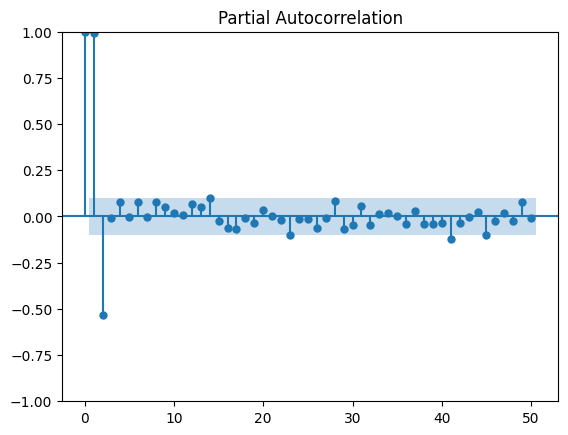

In [143]:
plt.figure(figsize=(12, 6))
plot_acf(df["Цена на арматуру"].dropna(), lags=50)
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df["Цена на арматуру"].dropna(), lags=50)
plt.show()

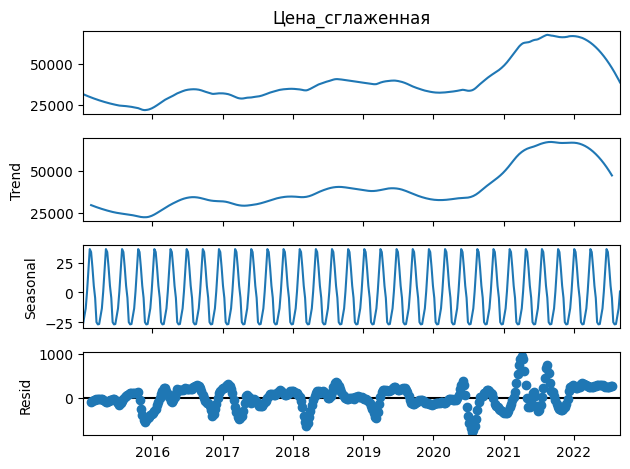

In [144]:
window_size = 55  
df["Цена_сглаженная"] = savgol_filter(df["Цена на арматуру"], window_length=window_size, polyorder=2)

result = seasonal_decompose(df["Цена_сглаженная"], model="additive", period=12)
df["Тренд"] = result.trend
result.plot()
plt.show()

In [145]:
df.dropna(inplace=True)

In [146]:
scaler = MinMaxScaler()
df["Цена_норм"] = scaler.fit_transform(df[["Цена_сглаженная"]])

In [147]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [148]:
# === ЛИНЕЙНАЯ РЕГРЕССИЯ ===
lr = LinearRegression()
lr.fit(np.arange(len(train)).reshape(-1, 1), train["Цена_сглаженная"])
test["lr_pred"] = lr.predict(np.arange(len(train), len(train) + len(test)).reshape(-1, 1))

# === ARIMA (автоматический подбор параметров) ===
arima_model = pm.auto_arima(train["Цена_сглаженная"], seasonal=True, m=12)
test["arima_pred"] = arima_model.predict(n_periods=len(test))

# === SARIMA ===
sarima_model = SARIMAX(train["Цена_сглаженная"], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12)).fit()
test["sarima_pred"] = sarima_model.forecast(steps=len(test))

# === RANDOM FOREST ===
rf = RandomForestRegressor(n_estimators=200, max_depth=10)
rf.fit(np.arange(len(train)).reshape(-1, 1), train["Цена_сглаженная"])
test["rf_pred"] = rf.predict(np.arange(len(train), len(train) + len(test)).reshape(-1, 1))

# === SVR ===
svr = SVR(kernel='rbf', C=100, gamma=0.1)
svr.fit(np.arange(len(train)).reshape(-1, 1), train["Цена_сглаженная"])
test["svr_pred"] = svr.predict(np.arange(len(train), len(train) + len(test)).reshape(-1, 1))

# === XGBOOST ===
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.05, max_depth=5, n_estimators=200)
xgb_model.fit(np.arange(len(train)).reshape(-1, 1), train["Цена_сглаженная"])
test["xgb_pred"] = xgb_model.predict(np.arange(len(train), len(train) + len(test)).reshape(-1, 1))

# === LSTM ===
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10
X_train, y_train = create_sequences(train["Цена_норм"].values, seq_length)
X_test, y_test = create_sequences(test["Цена_норм"].values, seq_length)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.3),
    LSTM(100, return_sequences=False),
    Dropout(0.3),
    Dense(50),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mean_squared_error")
lstm_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

lstm_pred = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

C:\Users\josha\AppData\Local\Temp\ipykernel_23560\1225639872.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["lr_pred"] = lr.predict(np.arange(len(train), len(train) + len(test)).reshape(-1, 1))
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\sklearn\

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


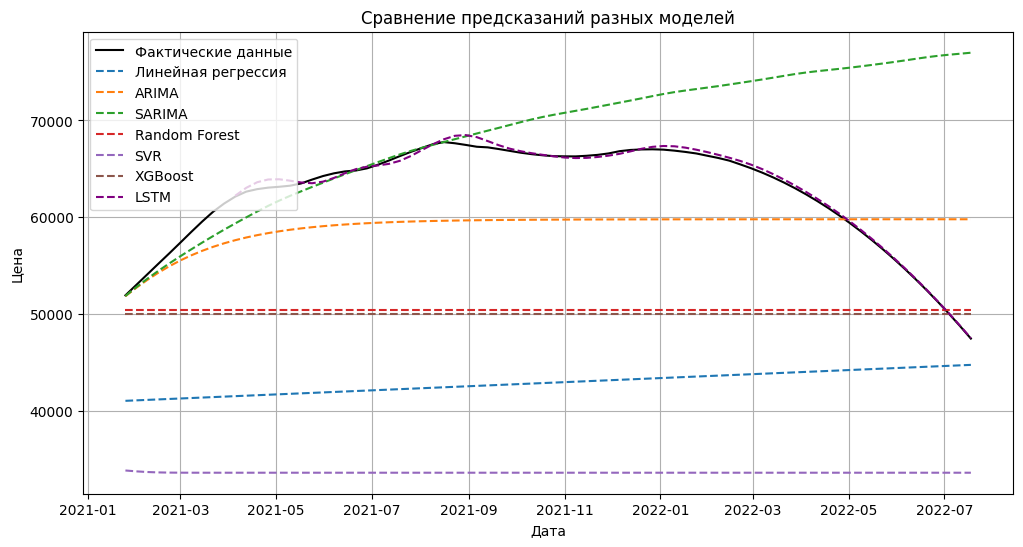

In [149]:
# График всех предсказаний
plt.figure(figsize=(12, 6))
plt.plot(test.index, test["Цена_сглаженная"], label="Фактические данные", color="black")
plt.plot(test.index, test["lr_pred"], label="Линейная регрессия", linestyle="dashed")
plt.plot(test.index, test["arima_pred"], label="ARIMA", linestyle="dashed")
plt.plot(test.index, test["sarima_pred"], label="SARIMA", linestyle="dashed")
plt.plot(test.index, test["rf_pred"], label="Random Forest", linestyle="dashed")
plt.plot(test.index, test["svr_pred"], label="SVR", linestyle="dashed")
plt.plot(test.index, test["xgb_pred"], label="XGBoost", linestyle="dashed")

# Добавление предсказаний LSTM (если есть)
if 'lstm_pred' in locals():
    plt.plot(test.index[-len(lstm_pred):], lstm_pred, label="LSTM", linestyle="dashed", color="purple")

plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Сравнение предсказаний разных моделей")
plt.legend()
plt.grid()
plt.show()
